In [46]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns

## About bayesian statistics

- Applied A.I: http://blog.applied.ai/bayesian-inference-with-pymc3-part-1/
- http://nbviewer.jupyter.org/github/aloctavodia/Doing_bayesian_data_analysis/blob/master/IPython/Kruschkes_Doing_Bayesian_Data_Analysis_in_PyMC3.ipynb
- pythonic preambulations: http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/
- mybridge

- http://fastml.com/bayesian-machine-learning/
- https://alexanderetz.com/understanding-bayes/
- Bayesian data analysis and cognitive modeling : http://www.sfs.uni-tuebingen.de/~mfranke/bda+cm2015/

## Mixture Density networks

- Bishop pattern recognition and machine learning: Mixture Density Networks page 272

## Generate data

- https://github.com/zer0n/deepframeworks/blob/master/README.md


#### about neural nets 
- http://www.demo.cs.brandeis.edu/pr/DIBA/
- evolutionary http://www.demo.cs.brandeis.edu/

- nnets cython: https://github.com/tburmeister/pyneural/tree/master/src


### How to make predictions with a bayesian model 
- https://www.youtube.com/watch?v=N4XpUocvz5E

### About dask
- https://jcrist.github.io/dask-sklearn-part-3.html

#### About streams

- https://blog.quantopian.com/bayesian-cone/

### Quickstart guide pymc3
- https://www.youtube.com/watch?v=rZvro4-nFIk

In [1]:
import generate_data
import matplotlib.pyplot as plt
import numpy as np
import theano 
import theano.tensor as T

X, Y = generate_data.generate_1dlinear_data()

## Learning the same data using a MLP
### variational.advi

In [2]:
X, Y = generate_data.generate_1dlinear_data()

In [6]:
X_train = X.reshape( (len(X),1))
Y_train = Y

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)

X_train shape (500, 1)
Y_train shape (500,)


In [11]:
import theano
import theano.tensor as T
import pymc3
import pymc3 as pm

std_val = 0.5
n_hidden = 5
input_dim = 1
output_dim = 1

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

# Initialize random weights between each layer
init_w1 = np.random.randn(input_dim , n_hidden)
init_b1 = np.random.randn(n_hidden)

init_w2 = np.random.randn(n_hidden, )
init_b2 = np.random.randn(output_dim )

mlp = pymc3.Model()

with mlp:
    #######################################
    # Prior distributions over parameters #
    #######################################
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_0_1', 0, sd=std_val, 
                             shape=(input_dim , n_hidden), 
                             testval=init_w1)
    
    bias_in_1 =  pm.Normal('b_1', 0, sd=1, 
                           shape= (n_hidden,), 
                           testval=init_b1)
            
    # Weights from 1st to 2nd (output) layer
    weights_1_out = pm.Normal('w_1_2', 0, sd=std_val, 
                              shape=(n_hidden, ), 
                              testval=init_w2)
    
    bias_in_2 =  pm.Normal('b_2', 0, sd=1, 
                           shape= (output_dim,), 
                           testval=init_b2)
    
    sigma = pymc3.HalfCauchy('sigma', beta=10, testval=1.)
    
    ####################
    # Model definition #
    ####################
    
    # Expected value of outcome
    act_1 = T.nnet.relu(T.dot(ann_input, weights_in_1) + bias_in_1)
    act_out = T.dot(act_1, weights_1_out) + bias_in_2

    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal('Y_obs', mu=act_out, observed=ann_output)
    Y_obs = pm.Normal('Y_obs', mu=act_out, sd=sigma, observed=ann_output)

Applied log-transform to sigma and added transformed sigma_log_ to model.


#### Train mlp using bayesian inference

In [12]:
with mlp:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    mu_params, sds_params, elbo = pymc3.variational.advi(n=20000)
    step = pm.NUTS(scaling=mlp.dict_to_array(sds_params))
    #trace = pymc3.sample(2000, step, start=mu, progressbar=True)
    trace = pm.sample(100, step, start=mu_params, progressbar=True)

Iteration 0 [0%]: ELBO = -57350.73
Iteration 2000 [10%]: Average ELBO = -13466.03
Iteration 4000 [20%]: Average ELBO = -2383.2
Iteration 6000 [30%]: Average ELBO = -1153.24
Iteration 8000 [40%]: Average ELBO = -980.28
Iteration 10000 [50%]: Average ELBO = -907.77
Iteration 12000 [60%]: Average ELBO = -857.19
Iteration 14000 [70%]: Average ELBO = -814.83
Iteration 16000 [80%]: Average ELBO = -784.32
Iteration 18000 [90%]: Average ELBO = -765.73
Finished [100%]: Average ELBO = -755.29
 [-----------------100%-----------------] 100 of 100 complete in 32.1 sec

In [13]:
plt.plot(elbo)

In [14]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2a73c20b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff2a6e00a90>]], dtype=object)

In [15]:
trace["w_0_1"].shape

(100, 1, 5)

In [16]:
trace["w_0_1"].mean(axis=0).shape

(1, 5)

In [17]:
trace["w_0_1"].mean(axis=0)

array([[ 0.04667962, -0.00099222, -0.03589969,  0.25469099, -0.06859419]])

In [18]:
###########################
# This should not be done #
###########################

X_train = X.reshape(len(X),1)
Y_train = Y

sym_input = T.dmatrix("sym_input")

# Defined shared variables of the model
sha_W1 = theano.shared(trace["w_0_1"].mean(axis=0))
sha_b1 = theano.shared(trace["b_1"].mean(axis=0))
sha_W2 = theano.shared(trace["w_1_2"].mean(axis=0))
sha_b2 = theano.shared(trace["b_2"].mean(axis=0))

act_1 = T.nnet.relu( T.dot(sym_input, sha_W1) + sha_b1)
act_out = T.dot(act_1, sha_W2) + sha_b2

In [19]:
predict = theano.function([sym_input],act_out)

In [20]:
x1_grid = np.linspace(-4, 4, 200)

x1_grid = np.array(x1_grid.reshape(len(x1_grid),1), dtype="float32" )

In [21]:
#predictions = predict(x1_grid)

### Making predictions

In [22]:
x1_grid = np.linspace(-4, 4, 200)

In [23]:
x1_grid = np.array(x1_grid.reshape(len(x1_grid),1), dtype="float32")

In [24]:
dummy_out = np.ones(x1_grid.shape[1], dtype=np.int8)

ann_input.set_value(x1_grid)
ann_output.set_value(dummy_out)

ppc = pm.sample_ppc(trace,
                    model=mlp, 
                    samples=2000)

In [25]:
predictions = ppc['Y_obs'].mean(axis=0)

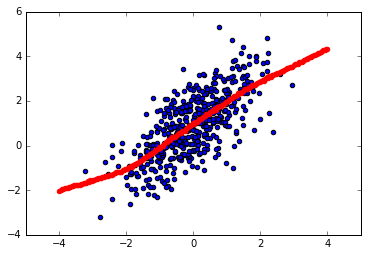

In [26]:
%matplotlib inline

## plot data
plt.scatter(X, Y)

# Write 
plt.scatter(x1_grid,
            predictions,
            color="r")

#### Plotting all models

For each mlp in the trace:
- get the parameters of the mlp 
- plot the predictions at each point in the grid.

In [27]:
sym_input = T.matrix("sym_input")

def model_prediction(X, w1, b1, w2, b2):

    # Expected value of outcome
    act_1 = T.nnet.relu(T.dot(X, w1) + b1)
    act_out = T.dot(act_1, w2) + b2
    
    return act_out.eval()

In [28]:
trace[0]

{'b_1': array([-1.16221878, -0.57015351,  0.06936257, -0.13949117, -1.02020538]),
 'b_2': array([ 1.06985216]),
 'sigma': 1.0456870870964787,
 'sigma_log_': 0.044674168972458676,
 'w_0_1': array([[ 0.00399206, -0.08269547, -1.08398951,  1.3028791 ,  0.02935333]]),
 'w_1_2': array([-0.01082504, -0.08859803, -0.94528767,  0.7187973 , -0.00219958])}

In [29]:
x1_grid = np.linspace(-4, 4, 200)
x1_grid = x1_grid.reshape((len(x1_grid),1))

x1_grid.shape

(200, 1)

In [30]:
k = 1
a = model_prediction(x1_grid,
                     trace["w_0_1"][k],
                     trace["b_1"][k],
                     trace["w_1_2"][k],
                     trace["b_2"][k])

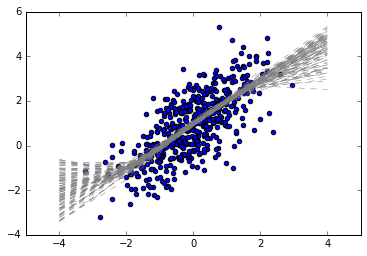

In [31]:
%matplotlib inline

## plot data
plt.scatter(X, Y)

num_models = len(trace)

for i in range(num_models):
    prediction = model_prediction(x1_grid,
                                  trace["w_0_1"][i],
                                  trace["b_1"][i],
                                  trace["w_1_2"][i],
                                  trace["b_2"][i])
    
    #import pdb;pdb.set_trace()
    plt.plot(x1_grid,
             prediction,
             color="grey",
             linestyle="--",
             linewidth=0.5)

### Computing the confidence of our predictions

Each element in trace has a "sigma" parameter

Make as many predictions as models in the trace, 

In [32]:
trace.varnames

['w_0_1', 'b_1', 'w_1_2', 'b_2', 'sigma_log_', 'sigma']

In [33]:
num_models = len(trace)
sigmas = []

for i in range(num_models):
    
    prediction = model_prediction(x1_grid,
                                  trace["w_0_1"][i],
                                  trace["b_1"][i],
                                  trace["w_1_2"][i],
                                  trace["b_2"][i])
    
    sigmas.append(trace["sigma"][i])

In [34]:
prediction.shape

(200,)

#### Given a feture assignment predict the target distribution

In [35]:
def gaussian(x, mu, var):
    return  (1./np.sqrt(2*np.pi*var)) * np.exp( -(x - mu)**2 /2*var)

In [36]:
gaussian(1,1,0.5)

0.56418958354775628

In [37]:
x1_grid[100], x1_grid[180]

(array([ 0.0201005]), array([ 3.2361809]))

In [38]:
def get_grid_centered_in_x(x, h, samples=200):
    return np.linspace(-x-h, x+h, samples)

In [39]:
a_from_grid = x1_grid[100]
b_from_grid = x1_grid[40]

In [40]:
a_from_grid, b_from_grid 

(array([ 0.0201005]), array([-2.3919598]))

#### a_from_grid

In [55]:
posterior_grid =  get_grid_centered_in_x(x=a_from_grid,
                                         h=4,
                                         samples=200)

In [60]:
model_m=-1
model_prediction(a_from_grid,
                                  trace["w_0_1"][model_m],
                                  trace["b_1"][model_m],
                                  trace["w_1_2"][model_m],
                                  trace["b_2"][model_m])

array([ 0.97995554])

In [42]:
posterior_grid.shape

(200,)

In [44]:
posteriors = []

for model_m in range(len(trace)):

    predict_x  = model_prediction(a_from_grid,
                                  trace["w_0_1"][model_m],
                                  trace["b_1"][model_m],
                                  trace["w_1_2"][model_m],
                                  trace["b_2"][model_m])
    variance = sigmas[model_m]

    posterior = []
    for x in posterior_grid:
        posterior.append(gaussian(x, mu=predict_x , var=variance ))
        
    posteriors.append(posterior)

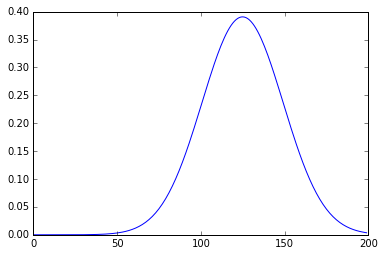

In [45]:
plt.plot(posteriors[40])

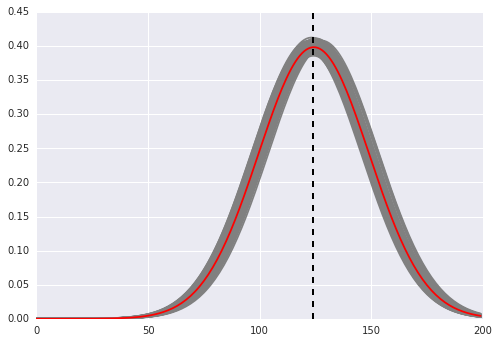

In [47]:
prob_t_given_x = np.mean(posteriors,axis=0)

for posterior in posteriors:
    plt.plot(posterior, color="grey")
    
plt.plot(prob_t_given_x, color="red")
plt.axvline(np.argmax(prob_t_given_x), 
            color="black", 
            linestyle='dashed',
            linewidth=2)

#### point b_from_grid

In [62]:
b_from_grid

array([-2.3919598])

In [61]:
a_from_grid

array([ 0.0201005])

In [48]:
posterior_grid =  get_grid_centered_in_x(x=b_from_grid,
                                         h=4,
                                         samples=200)

In [64]:

posteriors = []

for model_m in range(len(trace)):

    predict_x  = model_prediction(b_from_grid,
                                  trace["w_0_1"][model_m],
                                  trace["b_1"][model_m],
                                  trace["w_1_2"][model_m],
                                  trace["b_2"][model_m])
    variance = sigmas[model_m]

    posterior = []
    for x in posterior_grid:
        posterior.append(gaussian(x, mu=predict_x , var=variance ))
        
    posteriors.append(posterior)

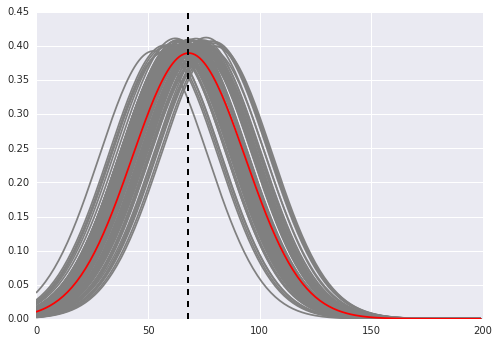

In [65]:
prob_t_given_x = np.mean(posteriors,axis=0)

for posterior in posteriors:
    plt.plot(posterior, color="grey")
    
plt.plot(prob_t_given_x, color="red")
plt.axvline(np.argmax(prob_t_given_x), 
            color="black", 
            linestyle='dashed',
            linewidth=2)

#### Recall sum of independent gaussians i a Gaussian 

- **A sum of independent (multivariate) Gaussians is (multivariate) Gaussian, with mean equal to the sum of the means, and covariance equal to the sum of the covariances.**

therefore:

- Given $N$ Gaussians defined with $(\mu_1,\sigma^2_1), \dots, (\mu_N,\sigma^2_N)$ the sum of gaussians is a gaussian with $\mu= \sum_{n=1}^N \mu_n$ and  $\sigma = \sum_{n=1}^N \sigma_n$

In [213]:
prob_t_given_x = np.mean(posteriors,axis=0)

In [205]:
prob_t_given_x.mean()

0.12303439185547656

In [195]:
np.array(posteriors[1]).shape

(200, 1)

In [197]:
prob_t_given_x [100]

array([ 0.24728342])

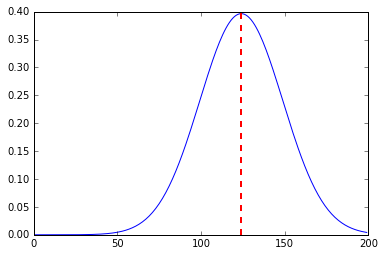

In [223]:
plt.plot(prob_t_given_x)
plt.axvline(np.argmax(prob_t_given_x), 
            color="red", 
            linestyle='dashed',
            linewidth=2)

## More complicated data

## Learning the same data using a MLP

### Using find_MAP

In [334]:
import theano
import theano.tensor as T
import pymc3
import pymc3 as pm

X_train = X.reshape(len(X),1)
Y_train = Y

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

# Initialize random weights between each layer
init_w1 = np.random.randn(input_dim , n_hidden)
init_b1 = np.random.randn(n_hidden)

init_w2 = np.random.randn(n_hidden, output_dim)
init_b2 = np.random.randn(output_dim )

In [335]:
mlp = pymc3.Model()

with mlp:
    #######################################
    # Prior distributions over parameters #
    #######################################
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_0_1', 0, sd=std_val, 
                             shape=(input_dim , n_hidden), 
                             testval=init_w1)
    
    bias_in_1 =  pm.Normal('b_1', 0, sd=1, 
                           shape= (n_hidden,), 
                           testval=init_b1)
            
    # Weights from 1st to 2nd (output) layer
    weights_1_out = pm.Normal('w_1_2', 0, sd=std_val, 
                              shape=(n_hidden,1 ), 
                              testval=init_w2)
    
    bias_in_2 =  pm.Normal('b_2', 0, sd=1, 
                           shape= (output_dim,), 
                           testval=init_b2)
    
    sigma = pymc3.HalfCauchy('sigma', beta=10, testval=1.)
    
    ####################
    # Model definition #
    ####################
    
    # Expected value of outcome
    act_1 = T.nnet.relu(T.dot(ann_input, weights_in_1) + bias_in_1)
    act_out = T.dot(act_1, weights_1_out) + bias_in_2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=act_out, observed=ann_output )
    #Y_obs = Normal('Y_obs', mu=act_out, sd=sigma, observed=ann_output)

Applied log-transform to sigma and added transformed sigma_log_ to model.


In [336]:
with mlp:
    # Inference!
    start = pymc3.find_MAP() # Find starting value by optimization
    step = pymc3.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pymc3.sample(200, step, start=start, progressbar=True) # draw 2000 posterior samples using NUTS sampling

 [-----------------100%-----------------] 200 of 200 complete in 253.0 sec

In [337]:
trace

<MultiTrace: 1 chains, 200 iterations, 6 variables>

In [338]:
mu_params

{'b_1': array([-1.03698313, -1.75303267, -1.40772628]),
 'b_2': array([ 0.91755864]),
 'sigma_log_': array(1.8085192723878076),
 'w_0_1': array([[ 0.01439613,  0.00627643,  0.00135914]]),
 'w_1_2': array([[-0.00173971],
        [ 0.00359032],
        [-0.00531535]])}

In [339]:
sds_params

{'b_1': array([ 0.60789399,  0.95192213,  0.74356073]),
 'b_2': array([ 0.16392472]),
 'sigma_log_': 1.6160920845222355,
 'w_0_1': array([[ 0.18706233,  0.17145043,  0.17812802]]),
 'w_1_2': array([[ 0.22876458],
        [ 0.15125377],
        [ 0.20315062]])}

In [340]:
trace["w_1_2"].shape

(200, 3, 1)

#### Looking at the trace 

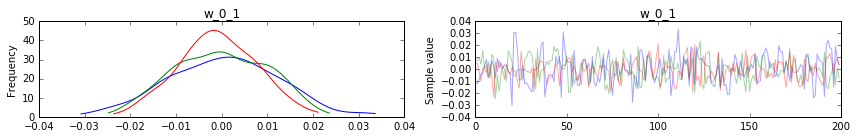

In [341]:
pm.traceplot(trace, ["w_0_1"]);

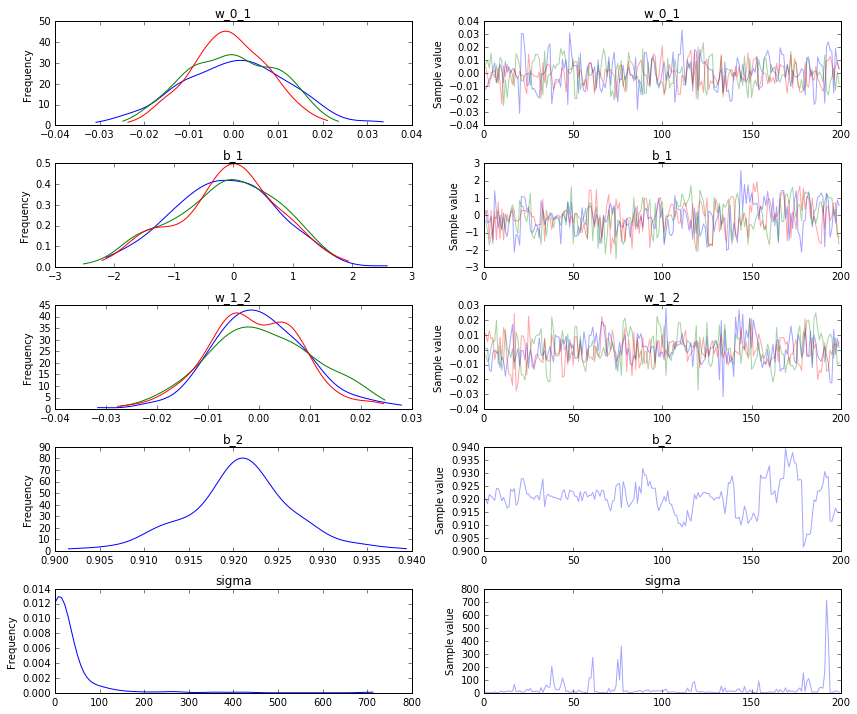

In [342]:
pm.traceplot(trace);

## solution plot

Now lets us:

- Take the learned weights and put them in the MLP object
- Make predictions using the mean value across the samples


In [343]:
trace["w_0_1"].shape

(200, 1, 3)

In [344]:
trace["w_0_1"].mean(axis=0).shape

(1, 3)

In [345]:
trace["w_0_1"].mean(axis=0)

array([[ 0.00045123, -0.00023542, -0.00087786]])

In [346]:
X_train = X.reshape(len(X),1)
Y_train = Y

sym_input = T.dmatrix("sym_input")

# Defined shared variables of the model
sha_W1 = theano.shared(trace["w_0_1"].mean(axis=0))
sha_b1 = theano.shared(trace["b_1"].mean(axis=0))
sha_W2 = theano.shared(trace["w_1_2"].mean(axis=0))
sha_b2 = theano.shared(trace["b_2"].mean(axis=0))

act_1 = T.nnet.relu( T.dot(sym_input, sha_W1) + sha_b1)
act_out = T.dot(act_1, sha_W2) + sha_b2
predict = theano.function([sym_input],act_out)

In [348]:
x1_grid.shape

(200,)

In [349]:
predictions = predict(x1_grid.reshape(len(x1_grid),1))

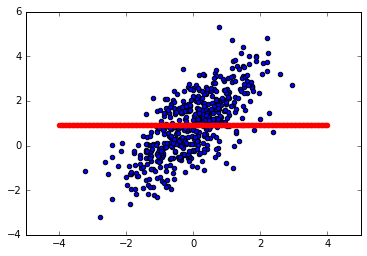

In [350]:
%matplotlib inline

## plot data
plt.scatter(X, Y)

# Write 
plt.scatter(x1_grid,
            predictions,
                color="r")

## Sinusoidal data

In [ ]:
X, Y  = generate_1dsinusoidal_data(num_samples=500, seed_val = 123)

## Modelling without mp.sample

In [ ]:
import theano
import theano.tensor as T
import pymc3
import pymc3 as pm
import numpy as np

X_train = np.vstack((X1,X2)).T
Y_train = Y

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

In [ ]:
std_val = 0.01
n_hidden = 3
input_dim = 2
output_dim = 1

In [ ]:
# Initialize random weights between each layer
init_w1 = np.random.randn(input_dim , n_hidden)
init_b1 = np.random.randn(n_hidden)

init_w2 = np.random.randn(n_hidden, output_dim)
init_b2 = np.random.randn(output_dim )

In [ ]:
mlp = pymc3.Model()

with mlp:
    #######################################
    # Prior distributions over parameters #
    #######################################
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=std_val, 
                             shape=(input_dim , n_hidden), 
                             testval=init_w1)
    
    bias_in_1 =  pm.Normal('b_in_1', 0, sd=1, 
                           shape= (n_hidden,), 
                           testval=init_b1)
            
    # Weights from 1st to 2nd (output) layer
    weights_1_out = pm.Normal('w_1_2', 0, sd=std_val, 
                              shape=(n_hidden,1 ), 
                              testval=init_w2)
    
    bias_in_2 =  pm.Normal('b_in_2', 0, sd=1, 
                           shape= (output_dim,), 
                           testval=init_b2)
    
    sigma = pymc3.HalfCauchy('sigma', beta=10, testval=1.)
    
    ####################
    # Model definition #
    ####################
    
    # Expected value of outcome
    act_1 = T.nnet.relu(T.dot(ann_input, weights_in_1) + bias_in_1)
    act_out = T.dot(act_1, weights_1_out) + bias_in_2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=act_out, observed=ann_output )
    #Y_obs = Normal('Y_obs', mu=act_out, sd=sigma, observed=ann_output)

In [ ]:
with mlp:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=10000)

In [ ]:
plt.plot(v_params.elbo_vals)

In [ ]:
v_params.elbo_vals.max()

In [ ]:
v_params.__dict__

In [ ]:
v_params[0]

In [ ]:
help(pm.variational)

About the evidence lower bounds

- https://benmoran.wordpress.com/2015/02/21/variational-bayes-and-the-evidence-lower-bound/

### Can't we sample? Sure but it's slow...

In [ ]:
with mlp:
    start = pymc3.find_MAP() # Find starting value by optimization
    step = pymc3.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pymc3.sample(100, step, start=start, progressbar=True) # draw 2000 posterior samples using NUTS sampling

## Fix parameters of the model and make predictions

### A little theano example

In [ ]:
sym_x = T.dmatrix('x')
s = 1 / (1 + T.exp(-sym_x))
logistic = theano.function([sym_x], s)

In [ ]:
logistic([[0, 1], [-1, -2]])

In [ ]:
sym_input = theano.tensor.matrix("sym_input")

np.random.seed(123)
init_w1 = np.random.randn(input_dim , n_hidden)
init_b1 = np.random.randn(n_hidden)

sha_W1 = theano.shared(init_w1)
sha_b1 = theano.shared(init_b1)

first_layer_act = T.nnet.relu(T.dot(sym_input , sha_W1 ) + sha_b1 )
acti = theano.function([sym_input],first_layer_act)

In [ ]:
acti(np.array([[23],[23]],dtype="float32"))